In [ ]:
# !git config --global user.email "mjgosavi@wisc.edu"
# !git config --global user.name "manasijg99"

In [ ]:
# !git clone https://github.com/Advaith789/brain-waves-classification.git

Cloning into 'brain-waves-classification'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 28 (delta 7), reused 19 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (28/28), 1.49 MiB | 6.44 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [ ]:
# %cd brain-waves-classification

/content/brain-waves-classification


In [ ]:
# !git pull

Already up to date.


In [ ]:
# %cd /content/brain-waves-classification

/content/brain-waves-classification


In [ ]:
# !mv /content/PCA.ipynb /content/brain-waves-classification/

mv: cannot stat '/content/PCA.ipynb': No such file or directory


In [ ]:
# !pwd

/content/brain-waves-classification


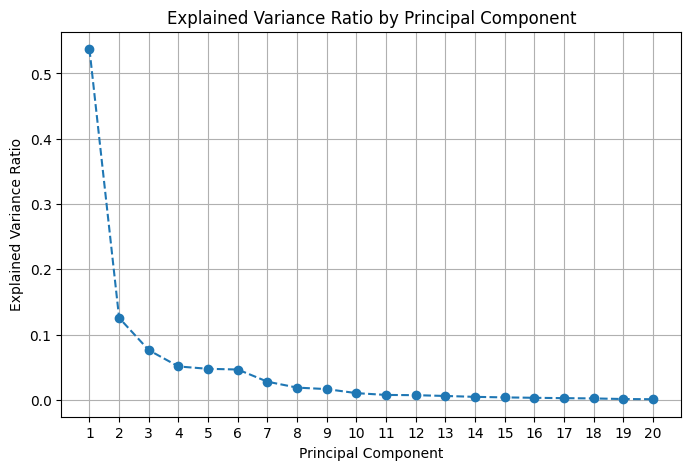

PC1: 0.5372
PC2: 0.1257
PC3: 0.0763
PC4: 0.0513
PC5: 0.0477
PC6: 0.0467
PC7: 0.0280
PC8: 0.0189
PC9: 0.0166
PC10: 0.0105
PC11: 0.0077
PC12: 0.0073
PC13: 0.0062
PC14: 0.0048
PC15: 0.0040
PC16: 0.0033
PC17: 0.0028
PC18: 0.0024
PC19: 0.0015
PC20: 0.0012


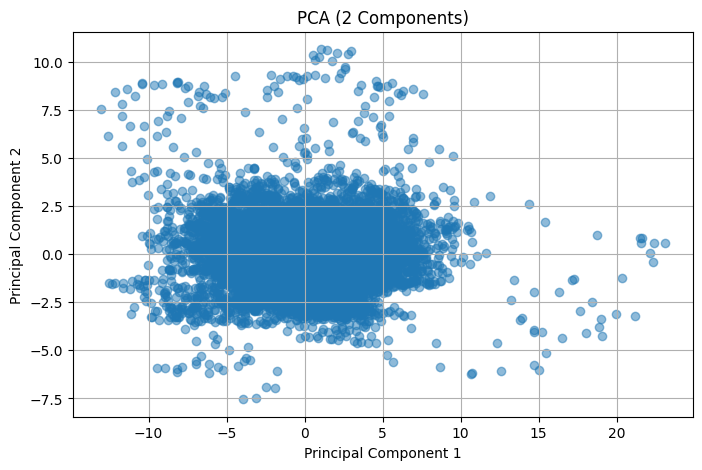

In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import CONSTANT

# Load the EEG parquet file
# Replace 'eeg_data.parquet' with your actual file path
eeg_df = pd.read_parquet(CONSTANT.PATH_TO_FILES_TRAIN_EEG+'/568657.parquet')

# List of EEG feature columns
eeg_features = CONSTANT.FEATURES

# Check if the features exist in the dataframe
missing_features = [feat for feat in eeg_features if feat not in eeg_df.columns]
if missing_features:
    print("Warning: The following features are missing from the dataframe:", missing_features)

# Filter the dataframe to only include the EEG features (if they exist)
data = eeg_df[eeg_features].dropna()  # Drop rows with missing values if any

# Standardize the features (mean=0, variance=1) since PCA is affected by scale.
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Perform PCA
# Here, we don't pre-specify the number of components; we can see the explained variance for each.
pca = PCA()
pca_result = pca.fit_transform(scaled_data)

# Create a DataFrame for the PCA result
pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])

# Plot the explained variance ratio to determine how many components to keep.
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Explained Variance Ratio by Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.grid(True)
plt.show()

# Optional: Print the explained variance for each component
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {ratio:.4f}")

# If you decide to keep a fixed number of components (e.g., 2 for visualization):
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(scaled_data)
plt.figure(figsize=(8, 5))
plt.scatter(pca_2_result[:, 0], pca_2_result[:, 1], alpha=0.5)
plt.title('PCA (2 Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

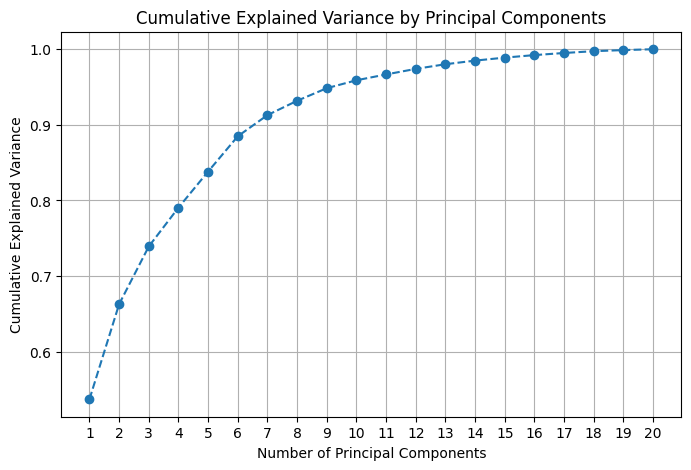

PC1: 0.5372
PC2: 0.1257
PC3: 0.0763
PC4: 0.0513
PC5: 0.0477
PC6: 0.0467
PC7: 0.0280
PC8: 0.0189
PC9: 0.0166
PC10: 0.0105
PC11: 0.0077
PC12: 0.0073
PC13: 0.0062
PC14: 0.0048
PC15: 0.0040
PC16: 0.0033
PC17: 0.0028
PC18: 0.0024
PC19: 0.0015
PC20: 0.0012


In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Assume pca is your fitted PCA instance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(range(1, len(cumulative_variance) + 1))
plt.grid(True)
plt.show()

# Print out the explained variance for each component
for i, ratio in enumerate(explained_variance):
    print(f"PC{i+1}: {ratio:.4f}")

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id

# Initialize Spark session
spark = SparkSession.builder.appName("EEGJoinExample").getOrCreate()

# Load the CSV file (ensure the correct path and options)
csv_df = spark.read.csv(CONSTANT.PATH_TO_TRAIN_CSV, header=True, inferSchema=True)

# Load the EEG parquet file
eeg_df = spark.read.parquet(CONSTANT.PATH_TO_FILES_TRAIN_EEG+'/568657.parquet')

# Now add index columns to both DataFrames
csv_df = csv_df.withColumn("index", monotonically_increasing_id())
eeg_df = eeg_df.withColumn("index", monotonically_increasing_id())

# Join on the index column
joined_df = csv_df.join(eeg_df, on="index", how="inner")

# Select the desired features and label (for example, "expert_consensus")
selected_data = joined_df.select("Fp1", "Fp2", "O1", "O2", "expert_consensus")
selected_data.show()

25/04/04 18:38:39 WARN Utils: Your hostname, Patrons-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 10.141.215.41 instead (on interface en0)
25/04/04 18:38:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).

25/04/04 18:38:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Py4JJavaError: An error occurred while calling None.org.apache.spark.api.java.JavaSparkContext.
: java.lang.UnsupportedOperationException: getSubject is not supported
	at java.base/javax.security.auth.Subject.getSubject(Subject.java:277)
	at org.apache.hadoop.security.UserGroupInformation.getCurrentUser(UserGroupInformation.java:577)
	at org.apache.spark.util.Utils$.$anonfun$getCurrentUserName$1(Utils.scala:2416)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.util.Utils$.getCurrentUserName(Utils.scala:2416)
	at org.apache.spark.SparkContext.<init>(SparkContext.scala:329)
	at org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
	at java.base/jdk.internal.reflect.DirectConstructorHandleAccessor.newInstance(DirectConstructorHandleAccessor.java:62)
	at java.base/java.lang.reflect.Constructor.newInstanceWithCaller(Constructor.java:499)
	at java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:483)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:238)
	at py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
	at py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1447)


In [ ]:
import os

# Define the path to your EEG file
eeg_file_path = CONSTANT.PATH_TO_FILES_TRAIN_EEG+'/568657.parquet'

# Extract the file name and remove the extension
eeg_id_value = os.path.splitext(os.path.basename(eeg_file_path))[0]
print("Extracted eeg_id:", eeg_id_value)

Extracted eeg_id: 568657


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
import os

# Initialize Spark session
spark = SparkSession.builder.appName("EEGClassificationSingleFile").getOrCreate()

# Define the EEG file path
eeg_file_path = CONSTANT.PATH_TO_FILES_TRAIN_EEG+'/568657.parquet'

# Extract the eeg_id from the file name
eeg_id_value = os.path.splitext(os.path.basename(eeg_file_path))[0]
print("Extracted eeg_id:", eeg_id_value)

# Load the metadata CSV file (adjust the path as needed)
metadata_csv_path = CONSTANT.PATH_TO_TRAIN_CSV
metadata_df = spark.read.csv(metadata_csv_path, header=True, inferSchema=True)

# Filter the metadata to get the record(s) for this eeg_id
metadata_for_eeg = metadata_df.filter(metadata_df.eeg_id == eeg_id_value)

# Load the EEG parquet file
eeg_df = spark.read.parquet(eeg_file_path)

# If the EEG parquet file does not already contain an 'eeg_id' column,
# add the extracted eeg_id as a new column to every row
eeg_df = eeg_df.withColumn("eeg_id", lit(eeg_id_value))

# Join the EEG data with its metadata using the common key (eeg_id)
joined_df = eeg_df.join(metadata_for_eeg, on="eeg_id", how="inner")

# For example, select your features and the label (assuming label column is 'expert_consensus')
selected_data = joined_df.select("Fp1", "Fp2", "O1", "O2", "expert_consensus")
selected_data.show(5, truncate=False)

# Proceed with your model training or further processing...

Extracted eeg_id: 568657
+-------+------+-----+-----+----------------+
|Fp1    |Fp2   |O1   |O2   |expert_consensus|
+-------+------+-----+-----+----------------+
|-75.36 |16.93 |89.87|72.55|Other           |
|-107.74|-13.23|53.31|40.25|Other           |
|-103.05|-9.2  |45.07|31.82|Other           |
|-75.1  |14.77 |67.65|62.51|Other           |
|-97.92 |-10.07|40.25|41.83|Other           |
+-------+------+-----+-----+----------------+
only showing top 5 rows



In [ ]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize a Spark session
spark = SparkSession.builder.appName("EEGClassification").getOrCreate()

# Define file paths
eeg_file_path = CONSTANT.PATH_TO_FILES_TRAIN_EEG+'/568657.parquet'
metadata_csv_path = CONSTANT.PATH_TO_TRAIN_CSV

# Extract the eeg_id from the file name (e.g., "568657" from "568657.parquet")
eeg_id_value = os.path.splitext(os.path.basename(eeg_file_path))[0]
print("Extracted eeg_id:", eeg_id_value)

# Load the metadata CSV file (ensure header is true and schema is inferred)
metadata_df = spark.read.csv(metadata_csv_path, header=True, inferSchema=True)

# Filter metadata to only include rows corresponding to the current eeg_id
# (Assuming the CSV has a column named "eeg_id")
metadata_for_eeg = metadata_df.filter(metadata_df.eeg_id == eeg_id_value)

# Load the EEG parquet file which contains your features
eeg_df = spark.read.parquet(eeg_file_path)

# If the EEG parquet file does not contain an 'eeg_id' column, add it manually using the extracted value
eeg_df = eeg_df.withColumn("eeg_id", lit(eeg_id_value))

# Join the EEG data with its corresponding metadata on the "eeg_id" column
joined_df = eeg_df.join(metadata_for_eeg, on="eeg_id", how="inner")

# Select the four desired features and the label.
# Here, we assume the label column from the CSV is "expert_consensus".
data = joined_df.select("Fp1", "Fp2", "O1", "O2", "expert_consensus")

# Convert the string label "expert_consensus" to a numeric column called "target"
# This is needed for logistic regression if the labels are not already numeric.
indexer = StringIndexer(inputCol="expert_consensus", outputCol="target")

# Assemble the four EEG features into a single vector column
assembler = VectorAssembler(inputCols=["Fp1", "Fp2", "O1", "O2"], outputCol="features")

# Scale the feature vector to normalize the data
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

# Define the logistic regression classifier for multi-class classification
lr = LogisticRegression(featuresCol="scaledFeatures", labelCol="target", maxIter=100, family="multinomial")

# Create a pipeline to chain all steps together
pipeline = Pipeline(stages=[indexer, assembler, scaler, lr])

# Split the data into training and test sets (80% training, 20% testing)
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Fit the model pipeline on the training data
model = pipeline.fit(train_data)

# Use the model to make predictions on the test data
predictions = model.transform(test_data)

# Show a few predictions with the original label (expert_consensus), numeric target, predicted label, and probabilities
predictions.select("expert_consensus", "target", "prediction", "probability").show(5, truncate=False)

# Evaluate the model using accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy:", accuracy)

# Stop the Spark session when finished
spark.stop()

Extracted eeg_id: 568657
+----------------+------+----------+-----------+
|expert_consensus|target|prediction|probability|
+----------------+------+----------+-----------+
|Other           |0.0   |0.0       |[1.0]      |
|Other           |0.0   |0.0       |[1.0]      |
|Other           |0.0   |0.0       |[1.0]      |
|Other           |0.0   |0.0       |[1.0]      |
|Other           |0.0   |0.0       |[1.0]      |
+----------------+------+----------+-----------+
only showing top 5 rows

Test Accuracy: 1.0


In [ ]:
import os, glob
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
from functools import reduce
from pyspark.sql import DataFrame

# Initialize Spark session
spark = SparkSession.builder.appName("MergeEEGParquetFiles").getOrCreate()

# Define the directory where all your EEG parquet files are stored
parquet_folder = CONSTANT.PATH_TO_FILES_TRAIN_EEG+'/'

# Use glob to list all parquet files in the directory
parquet_files = glob.glob(os.path.join(parquet_folder, "*.parquet"))

# Create an empty list to store DataFrames
dataframes = []

# Loop over each parquet file
for file_path in parquet_files:

    eeg_id = os.path.splitext(os.path.basename(file_path))[0]

    # Read the parquet file into a DataFrame and add a new column 'eeg_id'
    df = spark.read.parquet(file_path).withColumn("eeg_id", lit(eeg_id))

    # Append the DataFrame to the list
    dataframes.append(df)

# Union all DataFrames into one single DataFrame
if dataframes:
    combined_df = reduce(DataFrame.unionByName, dataframes)
else:
    combined_df = None

# Optionally, show the combined DataFrame's schema and a few rows
if combined_df:
    combined_df.printSchema()
    combined_df.show(5, truncate=False)

    # Write the merged DataFrame as a single parquet file
    combined_df.coalesce(1).write.mode("overwrite").parquet(CONSTANT.PATH_TO_MERGE_PARQUET+"/merged_output.parquet")

# Stop the Spark session when finished
spark.stop()

root
 |-- Fp1: float (nullable = true)
 |-- F3: float (nullable = true)
 |-- C3: float (nullable = true)
 |-- P3: float (nullable = true)
 |-- F7: float (nullable = true)
 |-- T3: float (nullable = true)
 |-- T5: float (nullable = true)
 |-- O1: float (nullable = true)
 |-- Fz: float (nullable = true)
 |-- Cz: float (nullable = true)
 |-- Pz: float (nullable = true)
 |-- Fp2: float (nullable = true)
 |-- F4: float (nullable = true)
 |-- C4: float (nullable = true)
 |-- P4: float (nullable = true)
 |-- F8: float (nullable = true)
 |-- T4: float (nullable = true)
 |-- T6: float (nullable = true)
 |-- O2: float (nullable = true)
 |-- EKG: float (nullable = true)
 |-- eeg_id: string (nullable = false)

+-----+-----+------+------+-----+------+------+------+-----+------+------+------+------+------+------+------+------+------+-----+-----+--------+
|Fp1  |F3   |C3    |P3    |F7   |T3    |T5    |O1    |Fz   |Cz    |Pz    |Fp2   |F4    |C4    |P4    |F8    |T4    |T6    |O2   |EKG  |eeg_id  |
+-

In [ ]:
from pyspark.sql import SparkSession

# Initialize the Spark session
spark = SparkSession.builder.appName("ViewMergedParquet").getOrCreate()

# Read the merged parquet file
merged_df = spark.read.parquet(CONSTANT.PATH_TO_MERGE_PARQUET+"/merged_output.parquet")  # Adjust path as needed

# Display the first 10 rows without truncation
merged_df.show(10, truncate=False)

# Optionally, print the schema to inspect the structure
merged_df.printSchema()

# Stop the Spark session when finished
spark.stop()

+-----+-----+------+------+-----+------+------+------+-----+------+------+------+------+------+------+------+------+------+-----+-----+--------+
|Fp1  |F3   |C3    |P3    |F7   |T3    |T5    |O1    |Fz   |Cz    |Pz    |Fp2   |F4    |C4    |P4    |F8    |T4    |T6    |O2   |EKG  |eeg_id  |
+-----+-----+------+------+-----+------+------+------+-----+------+------+------+------+------+------+------+------+------+-----+-----+--------+
|44.28|46.34|-5.29 |2.83  |40.88|-5.75 |-1.88 |-15.04|15.09|10.11 |-1.52 |15.83 |-1.7  |-9.28 |5.75  |1.92  |2.17  |7.99  |30.71|54.6 |10249311|
|44.38|45.1 |-9.02 |-0.8  |39.55|-6.87 |-3.93 |-19.13|13.36|6.64  |-5.7  |14.58 |-7.06 |-16.67|-0.36 |-4.71 |-5.51 |-0.64 |27.88|50.68|10249311|
|35.78|38.52|-13.76|-7.85 |33.17|-11.35|-8.77 |-25.17|7.27 |-1.62 |-11.04|7.15  |-11.09|-24.17|-8.58 |-11.96|-15.17|-9.95 |21.61|52.95|10249311|
|24.25|31.15|-19.84|-13.48|26.83|-17.96|-13.38|-29.23|-5.57|-10.93|-18.0 |-7.09 |-22.2 |-31.53|-16.49|-24.52|-24.27|-15.41|14.1 |4

In [ ]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("DistinctEEGIDs").getOrCreate()

# Read the merged parquet file
df = spark.read.parquet(CONSTANT.PATH_TO_MERGE_PARQUET+"/merged_output.parquet")

# Select distinct eeg_id values
distinct_ids = df.select("eeg_id").distinct()

# Show the distinct eeg_id values
distinct_ids.show(truncate=False)

# Optionally, print the count of distinct ids
print("Total distinct eeg_ids:", distinct_ids.count())

# Stop the Spark session when finished
spark.stop()

+--------+
|eeg_id  |
+--------+
|10386542|
|10343849|
|10617205|
|10687514|
|11127485|
|10466156|
|12197246|
|10859011|
|568657  |
|10249311|
+--------+

Total distinct eeg_ids: 10


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import collect_set

# Initialize Spark session
spark = SparkSession.builder.appName("JoinParquetWithCSV").getOrCreate()

# Read the merged Parquet file (which now includes an 'eeg_id' column)
parquet_df = spark.read.parquet(CONSTANT.PATH_TO_MERGE_PARQUET+"/merged_output.parquet")

# Read the CSV file containing metadata and labels (ensure header and schema inference are enabled)
csv_df = spark.read.csv(CONSTANT.PATH_TO_TRAIN_CSV, header=True, inferSchema=True)

# Inspect the columns to ensure both DataFrames have a common 'eeg_id' column
print("Parquet Columns:", parquet_df.columns)
print("CSV Columns:", csv_df.columns)

# Join the two DataFrames on the 'eeg_id' column
joined_df = parquet_df.join(csv_df, on="eeg_id", how="inner")

# Optionally, select a few columns to inspect, e.g., EEG features and label (assuming the label is 'expert_consensus')
selected_df = joined_df.select("eeg_id", "Fp1", "Fp2", "O1", "O2", "expert_consensus")

# Group by 'eeg_id' and collect distinct expert_consensus values into an array column
distinct_labels_df = selected_df.groupBy("eeg_id") \
                                .agg(collect_set("expert_consensus").alias("distinct_expert_consensus"))

# Show the result: distinct expert_consensus values for each eeg_id
distinct_labels_df.show(10, truncate=False)

# Optionally, print the count of distinct eeg_id groups
print("Total distinct eeg_id groups:", distinct_labels_df.count())

# Stop the Spark session when finished
spark.stop()

Parquet Columns: ['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG', 'eeg_id']
CSV Columns: ['eeg_id', 'eeg_sub_id', 'eeg_label_offset_seconds', 'spectrogram_id', 'spectrogram_sub_id', 'spectrogram_label_offset_seconds', 'label_id', 'patient_id', 'expert_consensus', 'seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
+--------+-------------------------+
|eeg_id  |distinct_expert_consensus|
+--------+-------------------------+
|10386542|[Other]                  |
|10343849|[GRDA]                   |
|10617205|[Other]                  |
|10687514|[Other]                  |
|11127485|[Seizure]                |
|12197246|[GPD]                    |
|10859011|[Seizure]                |
|568657  |[Other]                  |
|10249311|[Other]                  |
|10466156|[GRDA]                   |
+--------+-------------------------+

Total distinct eeg_id groups: 10


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, Imputer # Import Imputer here
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# 1. Start Spark session
spark = SparkSession.builder.appName("MultinomialLogisticRegressionEEG").getOrCreate()

# 2. Read the merged Parquet file
parquet_df = spark.read.parquet(CONSTANT.PATH_TO_MERGE_PARQUET+"/merged_output.parquet")

# 3. Read the CSV metadata
csv_df = spark.read.csv(CONSTANT.PATH_TO_TRAIN_CSV, header=True, inferSchema=True)

# 4. Join on 'eeg_id'
joined_df = parquet_df.join(csv_df, on="eeg_id", how="inner")

# 5. Cast your EEG feature columns to double and select the label column
#    This step ensures all numeric features are truly numeric in Spark.
#    Also, use Imputer to handle null values in the feature columns
data = joined_df.select(
    col("Fp1").cast("double").alias("Fp1"),
    col("Fp2").cast("double").alias("Fp2"),
    col("O1").cast("double").alias("O1"),
    col("O2").cast("double").alias("O2"),
    "expert_consensus"
)

# Create an Imputer to replace null values with the mean of the column
imputer = Imputer(
    inputCols=["Fp1", "Fp2", "O1", "O2"],
    outputCols=["Fp1", "Fp2", "O1", "O2"]  # Output to the same columns
).setStrategy("mean")  # Replace with mean

# 6. Index the string label into a numeric column called "label"
labelIndexer = StringIndexer(
    inputCol="expert_consensus",
    outputCol="label",
    handleInvalid="skip"  # skip rows that have invalid or missing labels
)

# 7. Assemble the four features into a single vector
assembler = VectorAssembler(
    inputCols=["Fp1", "Fp2", "O1", "O2"],
    outputCol="features"
)

# 8. Scale the features
scaler = StandardScaler(
    inputCol="features",
    outputCol="scaledFeatures",
    withStd=True,
    withMean=False
)

# 9. Create the logistic regression classifier
lr = LogisticRegression(
    featuresCol="scaledFeatures",
    labelCol="label",
    family="multinomial",
    maxIter=100
)

# 10. Build the pipeline
pipeline = Pipeline(stages=[imputer, labelIndexer, assembler, scaler, lr]) # Include imputer in the pipeline

# 11. Split into train/test sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# 12. Fit the pipeline model on the training data
model = pipeline.fit(train_data)

# 13. Predict on the test data
predictions = model.transform(test_data)

# 14. Show some predictions
predictions.select("expert_consensus", "label", "prediction", "probability").show(10, truncate=False)

# 15. Evaluate the model with accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy:", accuracy)

# 16. Stop the Spark session
spark.stop()

+----------------+-----+----------+----------------------------------------------------------------------------------+
|expert_consensus|label|prediction|probability                                                                       |
+----------------+-----+----------+----------------------------------------------------------------------------------+
|GRDA            |0.0  |0.0       |[0.955042723066719,0.015965934300687434,0.012645403592793845,0.016345939039799723]|
|GRDA            |0.0  |0.0       |[0.955042723066719,0.015965934300687434,0.012645403592793845,0.016345939039799723]|
|GRDA            |0.0  |0.0       |[0.955042723066719,0.015965934300687434,0.012645403592793845,0.016345939039799723]|
|GRDA            |0.0  |0.0       |[0.955042723066719,0.015965934300687434,0.012645403592793845,0.016345939039799723]|
|GRDA            |0.0  |0.0       |[0.955042723066719,0.015965934300687434,0.012645403592793845,0.016345939039799723]|
|GRDA            |0.0  |0.0       |[0.9550427230